# Assignment 1: CS583
### Name: Dhruv Vaghela
### CWID: 20015603

### Imports and util fetch function to pull data

In [136]:
import tensorflow as tf
import os
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import L2

%matplotlib inline

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

### Fetching data and one-hot encoding labels

In [119]:
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

(60000, 28, 28)

### Normalize train and test sets

In [120]:
image_size = X_train.shape[1]
input_size = image_size * image_size

X_train = np.reshape(X_train, [-1, input_size])
X_train = X_train.astype('float32') / 255
X_test = np.reshape(X_test, [-1, input_size])
X_test = X_test.astype('float32') / 255

## MNIST class and it's config

In [146]:
class MNIST:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = None
        self.image_size = 28
        self.input_size = self.image_size * self.image_size
        self.hidden_units = 500
        self.classes = 10
        self.bs = 64
        self.epochs = 250
        self.val_split = 0.2

    def train(self):
        return self.model.fit(self.X_train, self.y_train, batch_size=self.bs, epochs=self.epochs, validation_split=self.val_split)
        

    def evaluate(self):
        loss, acc = self.model.evaluate(self.X_test, self.y_test, batch_size=self.bs)
        return loss, acc
        

    def prepare_model(self, get_summary=False, regularizer=False, dropout=False):
        self.model = Sequential(name='MNIST')
        self.model.add(Dense(units=self.hidden_units, name='hidden_layer_1', activation='sigmoid', input_dim=self.input_size, kernel_regularizer=L2(0.01) if regularizer else None))
        if dropout:
            self.model.add(Dropout(0.2))
        self.model.add(Dense(units=self.hidden_units, name='hidden_layer_2', activation='sigmoid'))
        if dropout:
            self.model.add(Dropout(0.2))
        self.model.add(Dense(units=self.classes, name='output_layer', activation='softmax'))
        
        self.model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        if get_summary:
            self.model.summary()
        
        return self.model

In [147]:
mnist = MNIST(X_train, y_train, X_test, y_test)
model = mnist.prepare_model(regularizer=False)
h = mnist.train()

Epoch 1/250
683/750 [==========================>...] - ETA: 0s - loss: 2.2572 - accuracy: 0.1963

In [131]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Evaluation of MNIST Model

In [145]:
loss, acc = mnist.evaluate()

TypeError: cannot unpack non-iterable NoneType object

## MNIST Model with L2 regularization and dropout

In [138]:
mnist_l2 = MNIST(X_train, y_train, X_test, y_test)
mnist_l2.prepare_model(get_summary=True, regularizer=True, dropout=True)
h_l2 = mnist_l2.train()

Model: "MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 500)               392500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 hidden_layer_2 (Dense)      (None, 500)               250500    
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 output_layer (Dense)        (None, 10)                5010      
                                                                 
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
750/750 [==============================] - 

In [140]:
h_l2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plot of MNIST Model

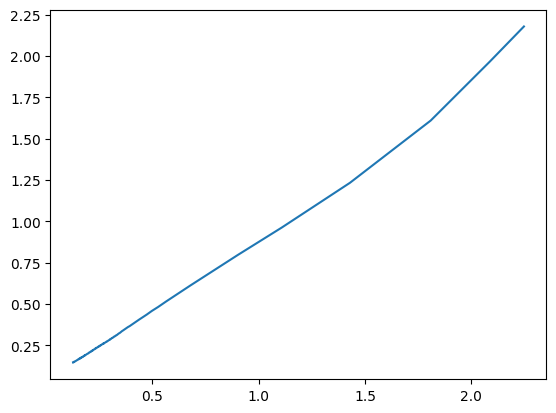

In [141]:
plt.plot(h.history['loss'], h.history['val_loss'])

### Plot of MNIST Model with L2 Regularization

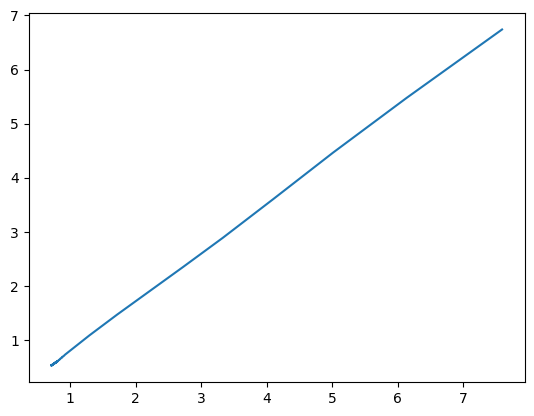

In [142]:
plt.plot(h_l2.history['loss'], h_l2.history['val_loss'])